# Solving the Traveling Salesman Problem with TrainSelPy

This notebook demonstrates how to solve the Traveling Salesman Problem (TSP) using the TrainSelPy package. We'll explore both single and multi-objective optimization approaches.

## The Traveling Salesman Problem

The Traveling Salesman Problem is a classic optimization problem: Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city exactly once and returns to the origin city?

We'll solve the TSP using TrainSelPy's genetic algorithm capabilities, and we'll see how multi-objective optimization can potentially improve the results.

In [11]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from typing import List, Dict, Any
import seaborn as sns

# Import TrainSelPy functions
from trainselpy import (
    make_data, 
    train_sel, 
    train_sel_control
)

## 1. Generate TSP Instance

First, let's generate a random TSP instance. We'll create cities with random coordinates and calculate the distance matrix.

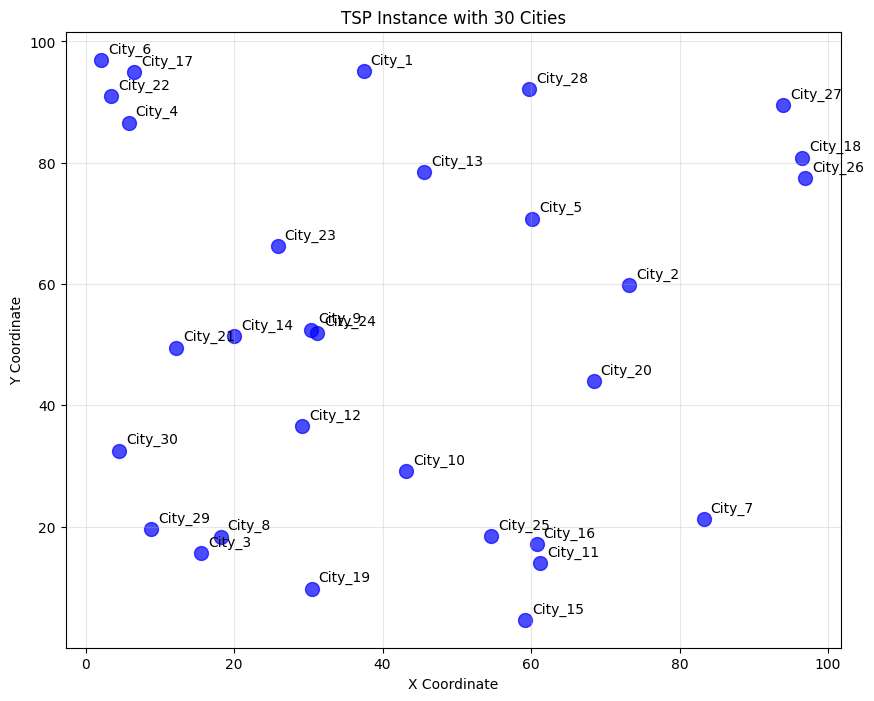

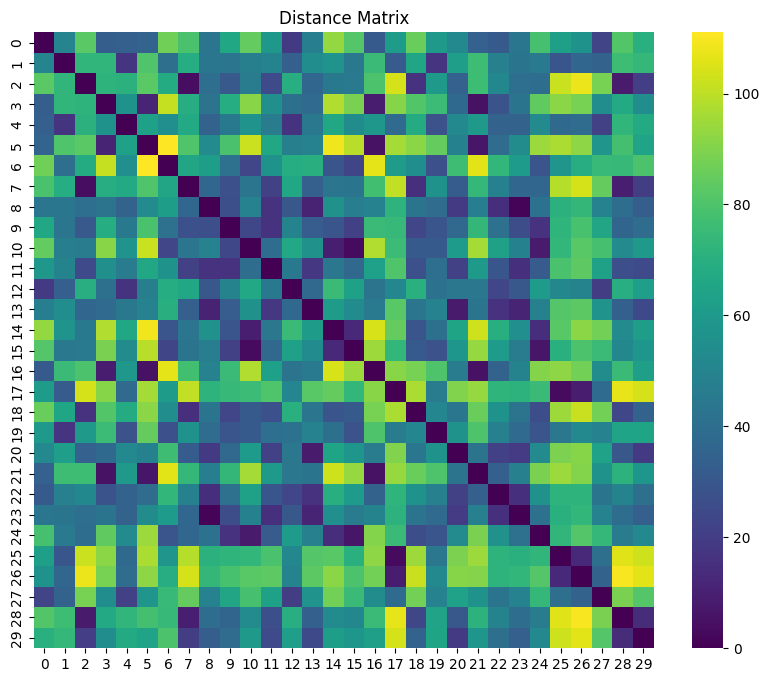

In [12]:
def generate_tsp_instance(n_cities=20, random_seed=42):
    """Generate a random TSP instance with n cities."""
    np.random.seed(random_seed)
    
    # Generate random city locations in a 2D space
    city_coords = np.random.rand(n_cities, 2) * 100
    
    # Calculate distance matrix
    distance_matrix = np.zeros((n_cities, n_cities))
    for i in range(n_cities):
        for j in range(n_cities):
            if i != j:
                # Euclidean distance
                distance_matrix[i, j] = np.sqrt(np.sum((city_coords[i] - city_coords[j])**2))
    
    # Create city names
    city_names = [f"City_{i+1}" for i in range(n_cities)]
    
    return {
        'city_coords': city_coords,
        'distance_matrix': distance_matrix,
        'city_names': city_names
    }

# Generate a random TSP instance
n_cities = 30
tsp_instance = generate_tsp_instance(n_cities)

# Visualize the cities
plt.figure(figsize=(10, 8))
plt.scatter(tsp_instance['city_coords'][:, 0], tsp_instance['city_coords'][:, 1], s=100, c='blue', alpha=0.7)

# Add city labels
for i, (x, y) in enumerate(tsp_instance['city_coords']):
    plt.annotate(tsp_instance['city_names'][i], (x, y), xytext=(5, 5), textcoords='offset points')

plt.title(f"TSP Instance with {n_cities} Cities")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(alpha=0.3)
plt.show()

# Display distance matrix
plt.figure(figsize=(10, 8))
sns.heatmap(tsp_instance['distance_matrix'], annot=False, cmap='viridis')
plt.title("Distance Matrix")
plt.show()

## 2. Define the TSP Evaluation Function

Now we'll define a function to evaluate the total distance of a tour.

Random tour: [18, 16, 4, 0, 24, 26, 29, 3, 12, 28, 14, 7, 8, 9, 20, 6, 5, 19, 22, 2, 27, 15, 13, 11, 1, 25, 21, 23, 10, 17]
Random tour distance: 1855.30


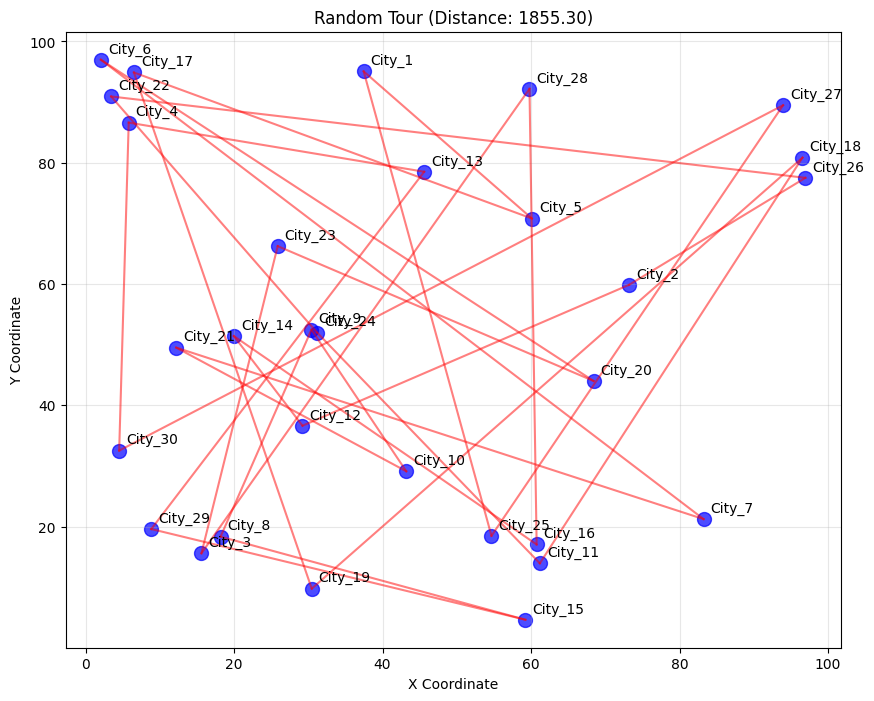

In [13]:

def ccw(A, B, C):
    return (C[1]-A[1]) * (B[0]-A[0]) > (B[1]-A[1]) * (C[0]-A[0])

def intersect(A, B, C, D):
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)

def count_edge_crossings(tour, coords):
    "Count the number of edge crossings in a tour."
    tour = np.array(tour)
    n = len(tour)
    crossings = 0
    
    # Get all edges
    edges = []
    for i in range(n):
        from_city = tour[i]
        to_city = tour[(i + 1) % n]
        edges.append((coords[from_city], coords[to_city]))
    
    # Check all pairs of non-adjacent edges
    for i in range(n):
        for j in range(i + 2, n):
            # Skip adjacent edge (last to first)
            if i == 0 and j == n - 1:
                continue
                
            p1, p2 = edges[i]
            p3, p4 = edges[j]
            
            if intersect(p1, p2, p3, p4):
                crossings += 1
                
    return crossings

def calculate_tour_distance(tour, distance_matrix):
    """Calculate the total distance of a tour."""
    # Ensure tour is a numpy array
    tour = np.array(tour)
    
    # Calculate total distance
    total_distance = 0
    for i in range(len(tour)):
        from_city = tour[i]
        to_city = tour[(i + 1) % len(tour)]  # Wrap around to the first city
        total_distance += distance_matrix[from_city, to_city]
    
    return total_distance

# Create a random tour and calculate its distance
random_tour = list(range(n_cities))
random.shuffle(random_tour)
random_distance = calculate_tour_distance(random_tour, tsp_instance['distance_matrix'])

print(f"Random tour: {random_tour}")
print(f"Random tour distance: {random_distance:.2f}")

# Visualize the random tour
plt.figure(figsize=(10, 8))
coords = tsp_instance['city_coords']

# Plot cities
plt.scatter(coords[:, 0], coords[:, 1], s=100, c='blue', alpha=0.7)

# Plot tour
for i in range(len(random_tour)):
    from_city = random_tour[i]
    to_city = random_tour[(i + 1) % len(random_tour)]
    plt.plot([coords[from_city, 0], coords[to_city, 0]], 
             [coords[from_city, 1], coords[to_city, 1]], 'r-', alpha=0.5)

# Add city labels
for i, (x, y) in enumerate(coords):
    plt.annotate(tsp_instance['city_names'][i], (x, y), xytext=(5, 5), textcoords='offset points')

plt.title(f"Random Tour (Distance: {random_distance:.2f})")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(alpha=0.3)
plt.show()

## 3. Single-Objective TSP Optimization

First, let's solve the TSP using a single objective (minimize total distance) with TrainSelPy.

Running single-objective TSP optimization...
Starting TrainSelPy optimization
Starting GA with population size 100
Initial best fitness: -1353.8361645788154
Generation 0: Best fitness = -1275.3203325960628
Generation 10: Best fitness = -1032.679067729029
Generation 20: Best fitness = -1016.0314394667083
Generation 30: Best fitness = -940.6780759646372
Generation 40: Best fitness = -846.4929099369643
Generation 50: Best fitness = -812.5114536227552
Generation 60: Best fitness = -776.358439680263
Generation 70: Best fitness = -773.1088643506894
Generation 80: Best fitness = -773.1088643506894
Generation 90: Best fitness = -731.8153197098419
Optimization completed in 1.15 seconds
Final fitness: -716.9696688977862
Optimization completed in 1.15 seconds
Best tour: [26, 25, 17, 6, 18, 7, 23, 8, 9, 19, 1, 4, 13, 20, 29, 2, 28, 11, 10, 24, 14, 15, 12, 21, 16, 5, 3, 22, 0, 27]
Best tour distance: 716.97
Improvement over random tour: 61.36%


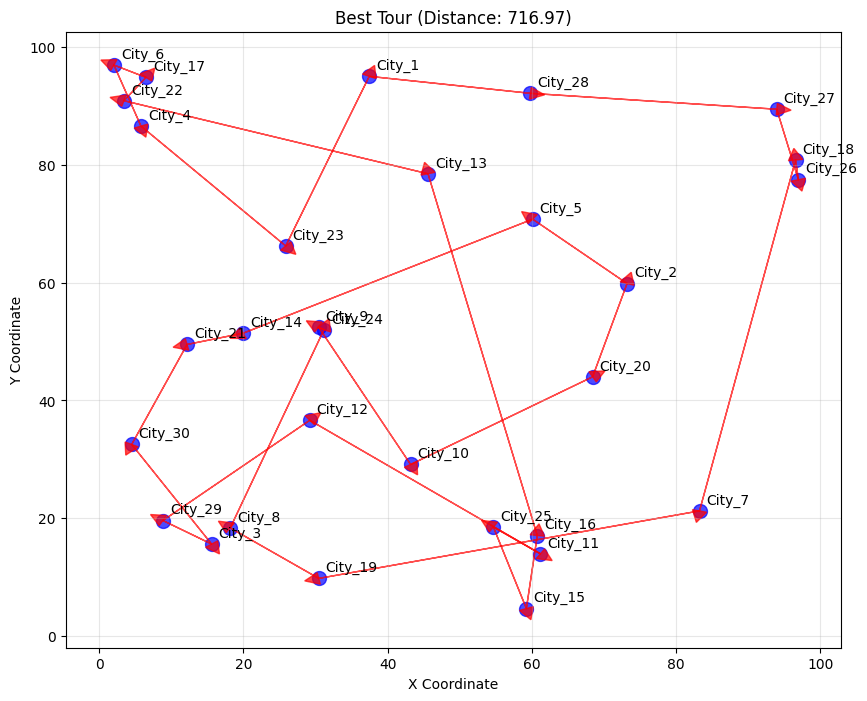

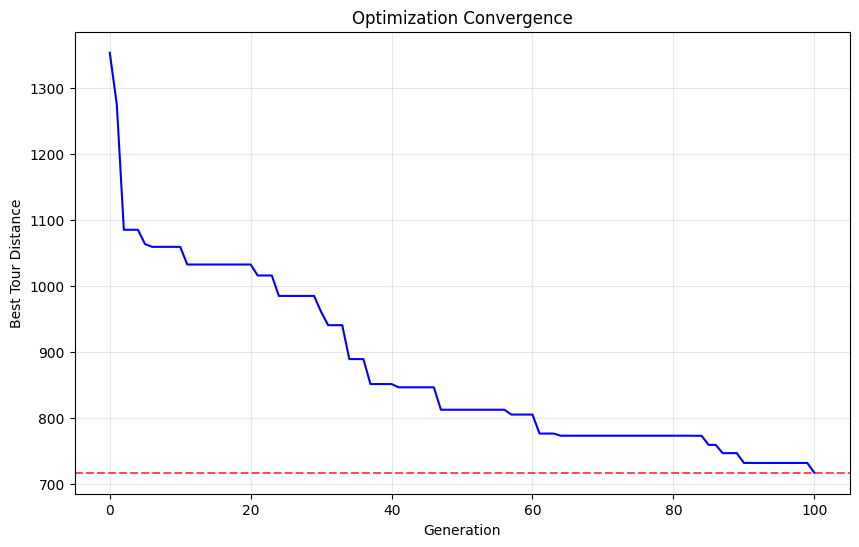

In [14]:
def tsp_objective(tour, data):
    """Objective function for TSP - minimize total distance."""
    distance_matrix = data['distance_matrix']
    
    # Calculate tour distance
    total_distance = calculate_tour_distance(tour, distance_matrix)
    
    # Return negative distance (for maximization in TrainSelPy)
    return -total_distance

# Create TrainSelPy data object
ts_data = make_data(M=np.eye(n_cities))  # Identity matrix as features (not used directly)
ts_data['distance_matrix'] = tsp_instance['distance_matrix']
ts_data['city_coords'] = tsp_instance['city_coords']
ts_data['city_names'] = tsp_instance['city_names']

# Set control parameters
control = train_sel_control(
    size="fixed",             # Fixed size selection
    niterations=100,          # Number of iterations
    minitbefstop=100,          # Minimum iterations before stopping
    nEliteSaved=10,           # Number of elite solutions to save
    nelite=40,                # Number of elite solutions
    npop=100,                 # Population size
    mutprob=.1,              # Mutation probability
    mutintensity=2,         # Mutation intensity
    crossprob=0.9,            # Crossover probability
    crossintensity=0.1,       # Crossover intensity
    niterSANN=200,             # Simulated annealing iterations
    tempini=100.0,            # Initial temperature
    tempfin=0.1,              # Final temperature
    progress=True             # Show progress
)

# Run the optimization
print("Running single-objective TSP optimization...")
start_time = time.time()

result = train_sel(
    data=ts_data,
    candidates=[list(range(n_cities))],  # All cities are candidates
    setsizes=[n_cities],                 # Select all cities
    settypes=["OS"],                     # Ordered set (order matters)
    stat=tsp_objective,                  # Objective function
    control=control,
    verbose=True
)

runtime = time.time() - start_time
print(f"Optimization completed in {runtime:.2f} seconds")

# Get best tour
best_tour = result.selected_indices[0]
best_distance = -result.fitness  # Convert back to positive distance

print(f"Best tour: {best_tour}")
print(f"Best tour distance: {best_distance:.2f}")
print(f"Improvement over random tour: {(random_distance - best_distance) / random_distance * 100:.2f}%")

# Visualize the best tour
plt.figure(figsize=(10, 8))
coords = tsp_instance['city_coords']

# Plot cities
plt.scatter(coords[:, 0], coords[:, 1], s=100, c='blue', alpha=0.7)

# Plot tour with directional arrows
for i in range(len(best_tour)):
    from_city = best_tour[i]
    to_city = best_tour[(i + 1) % len(best_tour)]
    
    # Draw arrow
    plt.arrow(coords[from_city, 0], coords[from_city, 1], 
              coords[to_city, 0] - coords[from_city, 0], 
              coords[to_city, 1] - coords[from_city, 1],
              head_width=2, head_length=2, fc='red', ec='red', alpha=0.7)

# Add city labels
for i, (x, y) in enumerate(coords):
    plt.annotate(tsp_instance['city_names'][i], (x, y), xytext=(5, 5), textcoords='offset points')

plt.title(f"Best Tour (Distance: {best_distance:.2f})")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(alpha=0.3)
plt.show()

# Plot convergence curve
plt.figure(figsize=(10, 6))
plt.plot(-np.array(result.fitness_history), 'b-')
plt.axhline(y=best_distance, color='r', linestyle='--', alpha=0.7)
plt.xlabel('Generation')
plt.ylabel('Best Tour Distance')
plt.title('Optimization Convergence')
plt.grid(alpha=0.3)
plt.show()

In [15]:

# Define Multi-Objective Fitness Function
def tsp_multi_objectives(tour, data):
    city_coords = data['city_coords']
    distance_matrix = data['distance_matrix']
    
    # Objective 1: Total Distance (minimize -> maximize negative)
    total_distance = calculate_tour_distance(tour, distance_matrix)
    
    # Objective 2: Max Segment Length (minimize -> maximize negative)
    max_segment = 0
    for i in range(len(tour)):
        from_city = tour[i]
        to_city = tour[(i + 1) % len(tour)]
        dist = distance_matrix[from_city, to_city]
        if dist > max_segment:
            max_segment = dist
            
    # Objective 3: Number of Crossings (minimize -> maximize negative)
    num_crossings = count_edge_crossings(tour, city_coords)
            
    return [-total_distance, -max_segment, -num_crossings]

print("Running Multi-Objective Optimization...")
start_time = time.time()

# Run optimization
result_moo = train_sel(
    data=ts_data,
    candidates=[list(range(n_cities))],
    setsizes=[n_cities],
    settypes=["OS"],
    stat=tsp_multi_objectives,
    n_stat=3,  # Three objectives
    control=control,
    verbose=True
)

print(f"Optimization completed in {time.time() - start_time:.2f} seconds")


Running Multi-Objective Optimization...
Starting TrainSelPy optimization
Starting GA with population size 100
Initial best fitness: -1568.6861317990383
Generation 0: Best fitness = -1338.0865657178806
Generation 10: Best fitness = -1122.5259694615434
Generation 20: Best fitness = -1066.9318180018297
Generation 30: Best fitness = -1028.2572004811168
Generation 40: Best fitness = -977.0776408679476
Generation 50: Best fitness = -976.8932341254456
Generation 60: Best fitness = -886.4096076158334
Generation 70: Best fitness = -819.8412182507773
Generation 80: Best fitness = -762.0368191061995
Generation 90: Best fitness = -753.1175847240943
Optimization completed in 45.49 seconds
Final fitness: -745.7841587174056
Optimization completed in 45.49 seconds


Found 4 solution(s) on the Pareto front

Best Solutions on the Pareto Front:

Best Total Distance Solution:
  Total Distance: 685.08
  Max Segment: 54.71
  Crossings: 6

Best Max Segment Solution:
  Total Distance: 690.41
  Max Segment: 52.64
  Crossings: 7

Best Crossing Solution:
  Total Distance: 712.42
  Max Segment: 54.71
  Crossings: 2

Balanced Solution:
  Total Distance: 690.41
  Max Segment: 52.64
  Crossings: 7


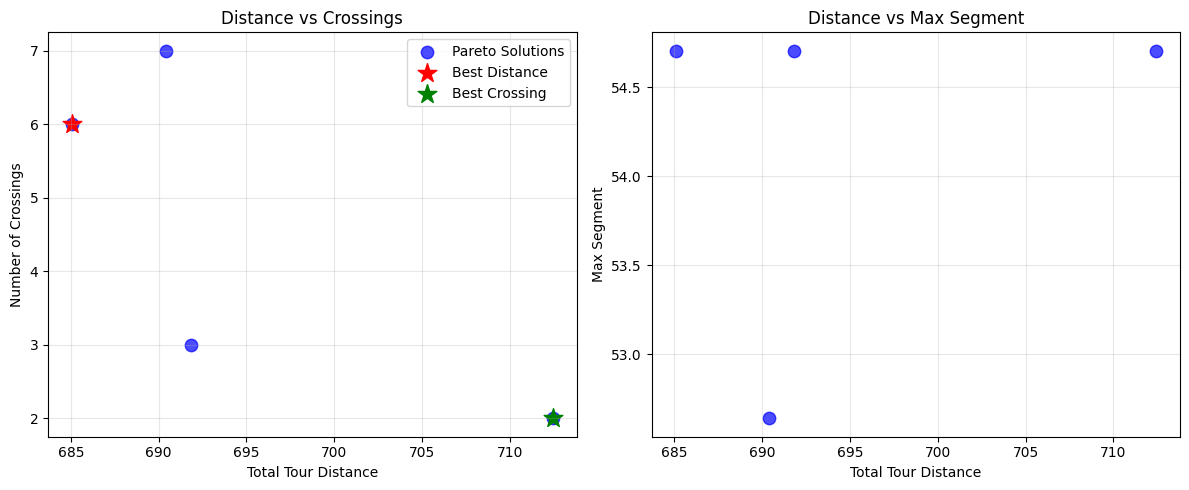

In [16]:
# Display Pareto front information
if result_moo.pareto_front:
    n_solutions = len(result_moo.pareto_front)
    print(f"Found {n_solutions} solution(s) on the Pareto front")
    
    # Convert objectives back to positive values
    total_distances = [-obj[0] for obj in result_moo.pareto_front]
    max_segments = [-obj[1] for obj in result_moo.pareto_front]
    num_crossings = [-obj[2] for obj in result_moo.pareto_front]
    
    # Find specific solutions
    best_total_idx = np.argmin(total_distances)
    best_segment_idx = np.argmin(max_segments)
    best_crossing_idx = np.argmin(num_crossings)
    
    # Calculate a balance score (normalized sum)
    # Add small epsilon to avoid division by zero
    def normalize(arr):
        if np.max(arr) == np.min(arr):
            return np.zeros_like(arr)
        return (arr - np.min(arr)) / (np.max(arr) - np.min(arr) + 1e-10)
        
    norm_total = normalize(np.array(total_distances))
    norm_segment = normalize(np.array(max_segments))
    norm_crossing = normalize(np.array(num_crossings))
    
    balance_scores = norm_total + norm_segment + norm_crossing
    balanced_idx = np.argmin(balance_scores)
    
    # Extract the actual tour for the balanced solution
    balanced_sol_control = result_moo.pareto_solutions[balanced_idx]
    balanced_tour = balanced_sol_control['selected_indices'][0]
    
    # Print information about notable solutions
    print("\nBest Solutions on the Pareto Front:")
    print(f"\nBest Total Distance Solution:")
    print(f"  Total Distance: {total_distances[best_total_idx]:.2f}")
    print(f"  Max Segment: {max_segments[best_total_idx]:.2f}")
    print(f"  Crossings: {num_crossings[best_total_idx]}")
    
    print(f"\nBest Max Segment Solution:")
    print(f"  Total Distance: {total_distances[best_segment_idx]:.2f}")
    print(f"  Max Segment: {max_segments[best_segment_idx]:.2f}")
    print(f"  Crossings: {num_crossings[best_segment_idx]}")
    
    print(f"\nBest Crossing Solution:")
    print(f"  Total Distance: {total_distances[best_crossing_idx]:.2f}")
    print(f"  Max Segment: {max_segments[best_crossing_idx]:.2f}")
    print(f"  Crossings: {num_crossings[best_crossing_idx]}")
    
    print(f"\nBalanced Solution:")
    print(f"  Total Distance: {total_distances[balanced_idx]:.2f}")
    print(f"  Max Segment: {max_segments[balanced_idx]:.2f}")
    print(f"  Crossings: {num_crossings[balanced_idx]}")
    
    if n_solutions > 1:
        # Plot Pareto front (2D projection of Distance vs Crossings)
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.scatter(total_distances, num_crossings, s=80, alpha=0.7, c='blue', label='Pareto Solutions')
        plt.scatter(total_distances[best_total_idx], num_crossings[best_total_idx], s=200, c='red', marker='*', label='Best Distance')
        plt.scatter(total_distances[best_crossing_idx], num_crossings[best_crossing_idx], s=200, c='green', marker='*', label='Best Crossing')
        plt.xlabel('Total Tour Distance')
        plt.ylabel('Number of Crossings')
        plt.title('Distance vs Crossings')
        plt.grid(alpha=0.3)
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.scatter(total_distances, max_segments, s=80, alpha=0.7, c='blue', label='Pareto Solutions')
        plt.xlabel('Total Tour Distance')
        plt.ylabel('Max Segment')
        plt.title('Distance vs Max Segment')
        plt.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()
else:
    print("No solutions found on the Pareto front.")


## 5. Comparison of Single-Objective and Multi-Objective Results

Let's compare the results from both optimization approaches.

Comparison of Single-Objective and Multi-Objective Results:

Single-Objective Solution:
  Total Distance: 716.97
  Max Segment: 63.30

Multi-Objective Balanced Solution:
  Total Distance: 690.41
  Max Segment: 52.64

Percent Differences:
  Total Distance: -3.70% better
  Max Segment: -16.85% better


/var/folders/8n/1l40cygn069cwys_v97vljmr0000gp/T/ipykernel_72742/3941272874.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


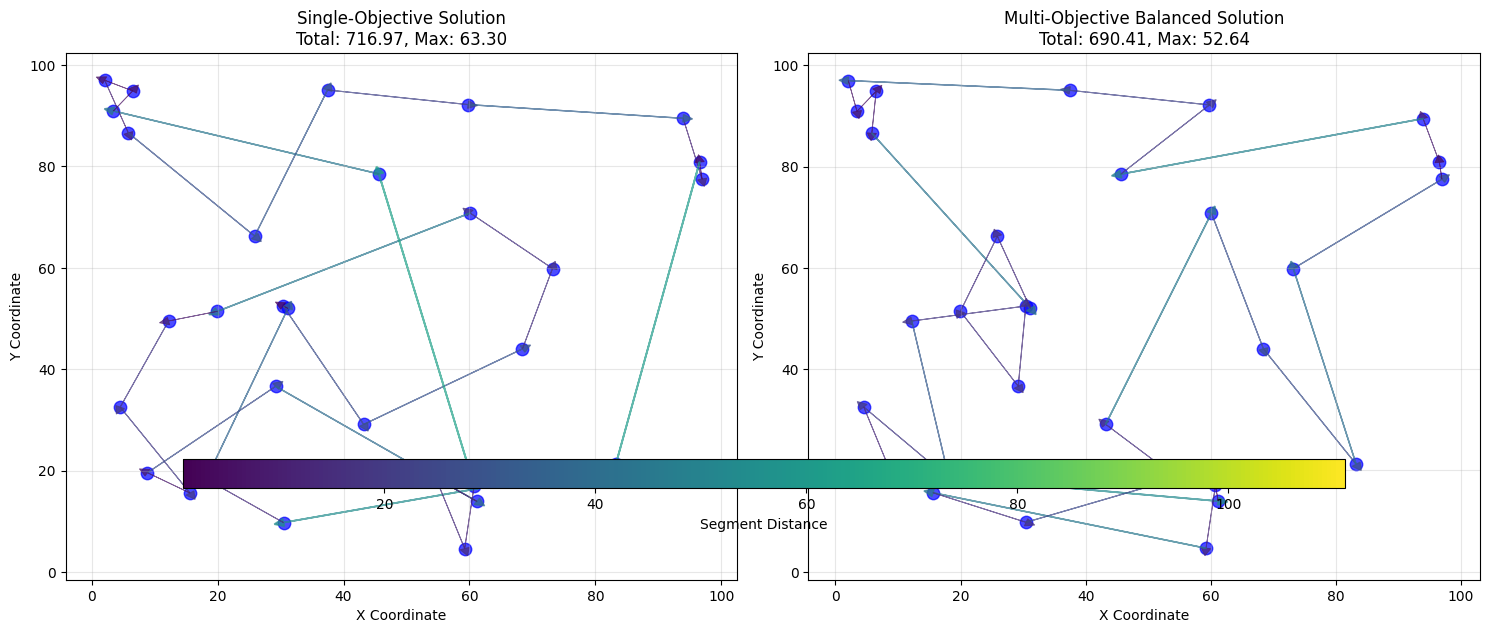

In [17]:
distance_matrix = tsp_instance['distance_matrix']
# Single-objective solution
single_obj_tour = best_tour
single_obj_total_distance = best_distance
single_obj_max_segment = 0

# Calculate max segment for single-objective solution
for i in range(len(single_obj_tour)):
    from_city = single_obj_tour[i]
    to_city = single_obj_tour[(i + 1) % len(single_obj_tour)]
    segment_distance = distance_matrix[from_city, to_city]
    single_obj_max_segment = max(single_obj_max_segment, segment_distance)

# Extract data for multi-objective solutions
if result_moo.pareto_front:
    # Extract data for multi-objective solutions
    moo_balanced_tour = balanced_tour
    moo_balanced_total_distance = total_distances[balanced_idx]
    moo_balanced_max_segment = max_segments[balanced_idx]
    
    # Compare single-objective and multi-objective solutions
    print("Comparison of Single-Objective and Multi-Objective Results:")
    print("\nSingle-Objective Solution:")
    print(f"  Total Distance: {single_obj_total_distance:.2f}")
    print(f"  Max Segment: {single_obj_max_segment:.2f}")
    
    print("\nMulti-Objective Balanced Solution:")
    print(f"  Total Distance: {moo_balanced_total_distance:.2f}")
    print(f"  Max Segment: {moo_balanced_max_segment:.2f}")
    
    # Calculate percent differences
    total_distance_diff = (moo_balanced_total_distance - single_obj_total_distance) / single_obj_total_distance * 100
    max_segment_diff = (moo_balanced_max_segment - single_obj_max_segment) / single_obj_max_segment * 100
    
    print("\nPercent Differences:")
    print(f"  Total Distance: {total_distance_diff:.2f}% {'worse' if total_distance_diff > 0 else 'better'}")
    print(f"  Max Segment: {max_segment_diff:.2f}% {'worse' if max_segment_diff > 0 else 'better'}")
    
    # Visual comparison of the two solutions
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Single-objective solution
    axes[0].scatter(coords[:, 0], coords[:, 1], s=80, c='blue', alpha=0.7)
    for i in range(len(single_obj_tour)):
        from_city = single_obj_tour[i]
        to_city = single_obj_tour[(i + 1) % len(single_obj_tour)]
        segment_distance = distance_matrix[from_city, to_city]
        
        # Color intensity based on segment distance
        norm_distance = (segment_distance - np.min(distance_matrix[distance_matrix > 0])) / \
                        (np.max(distance_matrix) - np.min(distance_matrix[distance_matrix > 0]))
        
        # Draw arrow with color intensity based on segment distance
        axes[0].arrow(coords[from_city, 0], coords[from_city, 1], 
                     coords[to_city, 0] - coords[from_city, 0], 
                     coords[to_city, 1] - coords[from_city, 1],
                     head_width=1.5, head_length=1.5, 
                     fc=plt.cm.viridis(norm_distance), 
                     ec=plt.cm.viridis(norm_distance), 
                     alpha=0.7, linewidth=1.5*norm_distance+0.5)
    
    axes[0].set_title(f"Single-Objective Solution\nTotal: {single_obj_total_distance:.2f}, Max: {single_obj_max_segment:.2f}")
    axes[0].set_xlabel("X Coordinate")
    axes[0].set_ylabel("Y Coordinate")
    axes[0].grid(alpha=0.3)
    
    # Multi-objective balanced solution
    axes[1].scatter(coords[:, 0], coords[:, 1], s=80, c='blue', alpha=0.7)
    for i in range(len(moo_balanced_tour)):
        from_city = moo_balanced_tour[i]
        to_city = moo_balanced_tour[(i + 1) % len(moo_balanced_tour)]
        segment_distance = distance_matrix[from_city, to_city]
        
        # Color intensity based on segment distance
        norm_distance = (segment_distance - np.min(distance_matrix[distance_matrix > 0])) / \
                        (np.max(distance_matrix) - np.min(distance_matrix[distance_matrix > 0]))
        
        # Draw arrow with color intensity based on segment distance
        axes[1].arrow(coords[from_city, 0], coords[from_city, 1], 
                     coords[to_city, 0] - coords[from_city, 0], 
                     coords[to_city, 1] - coords[from_city, 1],
                     head_width=1.5, head_length=1.5, 
                     fc=plt.cm.viridis(norm_distance), 
                     ec=plt.cm.viridis(norm_distance), 
                     alpha=0.7, linewidth=1.5*norm_distance+0.5)
    
    axes[1].set_title(f"Multi-Objective Balanced Solution\nTotal: {moo_balanced_total_distance:.2f}, Max: {moo_balanced_max_segment:.2f}")
    axes[1].set_xlabel("X Coordinate")
    axes[1].set_ylabel("Y Coordinate")
    axes[1].grid(alpha=0.3)
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=np.min(distance_matrix[distance_matrix > 0]), 
                                                                       vmax=np.max(distance_matrix)))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axes, orientation='horizontal', pad=0.05, aspect=40)
    cbar.set_label('Segment Distance')
    
    plt.tight_layout()
    plt.show()

## 5. Neural Network Enhanced Optimization

TrainSelPy also supports using neural networks (VAE/GAN) to learn the structure of high-quality solutions and generate better offspring. This is particularly useful for complex problems where standard genetic operators might get stuck in local optima.


In [18]:
# Create NN-enabled control parameters
control_nn = train_sel_control(
    size="fixed",
    niterations=100,
    minitbefstop=100,
    nEliteSaved=10,
    nelite=10,
    npop=100,
    mutprob=.1,
    mutintensity=2,
    crossprob=0.9,
    crossintensity=0.1,
    niterSANN=100,
    tempini=100.0,
    tempfin=0.1,
    progress=True,
    
    # Neural Network Parameters
    use_vae=True,
    use_gan=False,
    nn_epochs=10,
    nn_update_freq=5,
    nn_start_gen=5
)

# Run the optimization with NN
print("Running NN-enhanced TSP optimization...")
start_time = time.time()

result_nn = train_sel(
    data=ts_data,
    candidates=[list(range(n_cities))],
    setsizes=[n_cities],
    settypes=["OS"],
    stat=tsp_objective,
    control=control_nn,
    verbose=True
)

runtime_nn = time.time() - start_time
print(f"Optimization completed in {runtime_nn:.2f} seconds")

# Get best tour
best_tour_nn = result_nn.selected_indices[0]
best_distance_nn = -result_nn.fitness

print(f"Best tour distance (NN): {best_distance_nn:.2f}")

Running NN-enhanced TSP optimization...
Starting TrainSelPy optimization
Starting GA with population size 100
Initial best fitness: -1221.4826399396795
Initialized VAE (latent=32, beta=1.0)
Generation 0: Best fitness = -1221.4826399396795
  [NN] Training VAE on 100 samples for 10 epochs...
  [VAE] Epoch 10: Loss=77.5704
  [NN] Generated 20 neural offspring
  [NN] Generated 20 neural offspring
  [NN] Generated 20 neural offspring
  [NN] Generated 20 neural offspring
  [NN] Generated 20 neural offspring
  [NN] Training VAE on 100 samples for 10 epochs...
  [VAE] Epoch 10: Loss=66.2672
  [NN] Generated 20 neural offspring
Generation 10: Best fitness = -1046.2723045032496
  [NN] Generated 20 neural offspring
  [NN] Generated 20 neural offspring
  [NN] Generated 20 neural offspring
  [NN] Generated 20 neural offspring
  [NN] Training VAE on 100 samples for 10 epochs...
  [VAE] Epoch 10: Loss=46.1052
  [NN] Generated 20 neural offspring
  [NN] Generated 20 neural offspring
  [NN] Generated 2

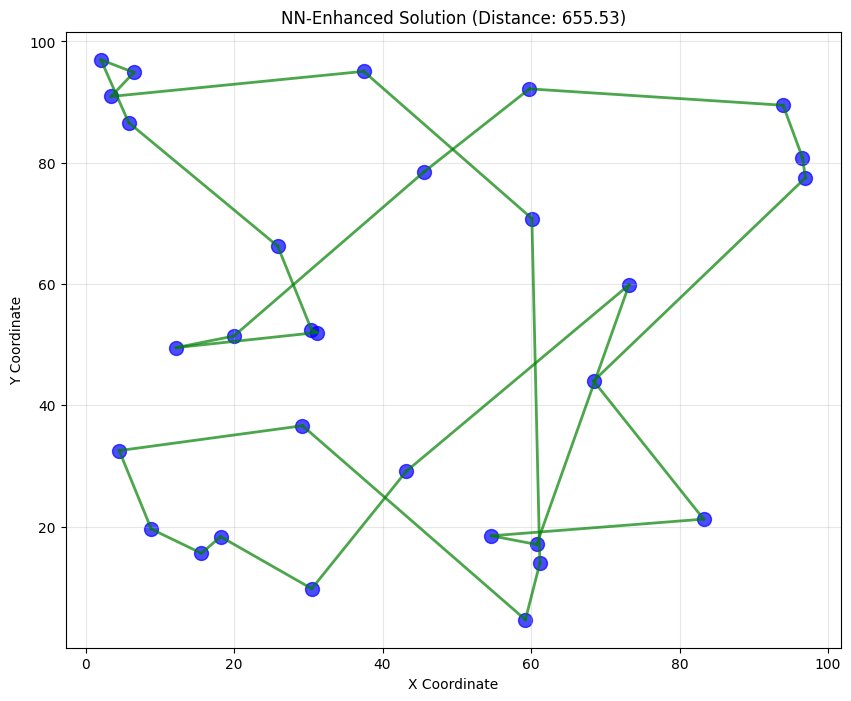

In [19]:
# Visualize the NN solution
plt.figure(figsize=(10, 8))

# Plot cities
plt.scatter(coords[:, 0], coords[:, 1], s=100, c='blue', alpha=0.7)

# Plot tour
for i in range(len(best_tour_nn)):
    from_city = best_tour_nn[i]
    to_city = best_tour_nn[(i + 1) % len(best_tour_nn)]
    plt.plot([coords[from_city, 0], coords[to_city, 0]], 
             [coords[from_city, 1], coords[to_city, 1]], 'g-', alpha=0.7, linewidth=2)

plt.title(f"NN-Enhanced Solution (Distance: {best_distance_nn:.2f})")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(alpha=0.3)
plt.show()

## 6. Conclusion

We've solved the Traveling Salesman Problem using two approaches with TrainSelPy:

1. **Single-Objective Optimization**: Focused solely on minimizing the total tour distance. This approach gives the shortest overall tour but may include some long individual segments.

2. **Multi-Objective Optimization**: Balanced two objectives - minimizing total distance and minimizing the maximum segment length. This approach provides more options with different trade-offs between total distance and maximum segment length.

The multi-objective approach offers more flexibility for real-world scenarios where multiple factors need to be considered. For example, in a real delivery route, minimizing the longest individual segment might be important for fuel planning or driver scheduling, even if it slightly increases the total distance.

TrainSelPy's genetic algorithm capabilities prove effective for both approaches, demonstrating its versatility in solving complex optimization problems.